# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [38]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [39]:
# Supposed to use cross-validation to find the optimal number of hidden neurons
from common_utils import CustomDataset, preprocess_dataset, split_dataset
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    batch_sizes = parameters
    
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
    
    for train_idx, val_idx in cv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        standard_scaler = preprocessing.StandardScaler()
        X_train_fold_scaled = standard_scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = standard_scaler.fit_transform(X_val_fold)
        
        for batch_size in batch_sizes:
            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

def preprocess(df):
    
    X_train, y_train, X_test, y_test = split_dataset(df, 'filename', 0.30, 1)
    X_train = X_train.drop(columns=['label'])
    X_test = X_test.drop(columns=['label'])
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train, y_train, X_test, y_test = preprocess(df)

class FirstHiddenLayerMLP(nn.Module):

    def __init__(self, no_features, no_hidden_first_layer, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden_first_layer),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden_first_layer, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
         logits = self.mlp_stack(x)
         return logits
    
class BatchCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def intialise_loaders_batch(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):

    train_data = BatchCustomDataset(X_train_scaled,y_train)
    test_data = BatchCustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop_batch(dataloader, model, loss_fn, optimizer, x_test, y_test):

    acc_ = []
    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = model(torch.tensor(x_test, dtype=torch.float))

        acc__ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float)).type(torch.float).mean()
        
        acc_.append(acc__.item())
        
    return acc_

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [40]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    
    epochs = 100
    times = []
    train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train2, X_val_scaled, y_val2)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    tr_loss, tr_correct = [], []
    te_loss, te_correct = [], []
    for t in range(epochs):
        train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

        tr_loss.append(train_loss), tr_correct.append(train_correct)
        te_loss.append(test_loss), te_correct.append(test_correct)
        times.append(t+1)
        
        print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
        
    train_accuracies = tr_correct
    train_losses = tr_loss
    test_accuracies = te_correct
    test_losses = te_loss

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [41]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    
    # So now we are only passing in one batch size, so each dict should be of size 1*5
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_size,X_train,y_train)

    cross_validation_times = []
    foldaccuracyofabatchsize = []
    timeforafoldforthatbatchsize = []
    meanaccuracyofabatchsizelist = []
    meantimeofabatchsizelist = []
    for no_neurons in parameters:
        model = FirstHiddenLayerMLP(77,no_neurons,2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        foldaccuracyofabatchsize = []
        timeforafoldforthatbatchsize = []
        for idxy in range(0,5):
            x_train = X_train_scaled_dict[batch_size[0]][idxy]
            y_train = y_train_dict[batch_size[0]][idxy]
            x_val = X_val_scaled_dict[batch_size[0]][idxy]
            y_val = y_val_dict[batch_size[0]][idxy]
            train_dataloader, test_dataloader = intialise_loaders_batch(x_train, y_train, x_val, y_val, batch_size[0])

            for epoch in range(100):
                start = time.time()
                acc_ = train_loop_batch(train_dataloader, model, loss_fn, optimizer, x_val, y_val)
                end = time.time()
                    # for a fold, the list of accuracies for the batches of that epoch^
                if epoch==99:
                    foldaccuracyofabatchsize.append(np.mean(np.array(acc_), axis = 0))
    #                    the accuracy for the last epoch of that fold - the fold accuracy for that batch size, length is 5
                    timeforafoldforthatbatchsize.append(end-start)
        meanaccuracyofabatchsizelist.append(np.mean(np.array(foldaccuracyofabatchsize), axis = 0))
        meantimeofabatchsizelist.append(np.mean(np.array(timeforafoldforthatbatchsize), axis = 0))        


    cross_validation_accuracies = meanaccuracyofabatchsizelist
    cross_validation_times = meantimeofabatchsizelist
    print(cross_validation_accuracies)
    print(cross_validation_times)
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 1024. Fill your optimal batch size in the following code.
'''
optimal_bs = [1024]
num_neurons = [64,128,256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, num_neurons, 'num_neurons', optimal_bs)

[0.7709167872156415, 0.8121899468558175, 0.8427458337375094]
[0.8322426319122315, 1.2004170894622803, 1.7339676856994628]


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

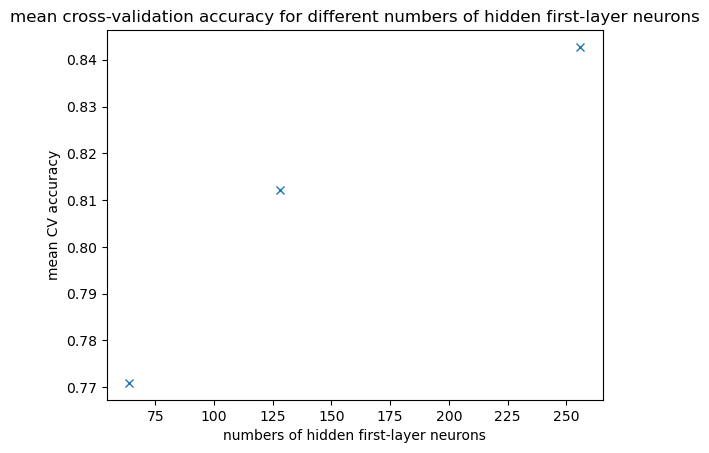

In [42]:
plt.plot(num_neurons, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy for different numbers of hidden first-layer neurons')
plt.xlabel('numbers of hidden first-layer neurons')
plt.ylabel('mean CV accuracy')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [43]:
optimal_neurons = 256
reason = "Highest mean CV accuracy"
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Epoch 1: Train_accuracy: 52.21%, Train_loss: 0.691968, Test_accuracy: 52.54%, Test_loss: 0.689203
Epoch 2: Train_accuracy: 55.35%, Train_loss: 0.686176, Test_accuracy: 56.52%, Test_loss: 0.682654
Epoch 3: Train_accuracy: 57.57%, Train_loss: 0.677357, Test_accuracy: 57.08%, Test_loss: 0.677659
Epoch 4: Train_accuracy: 59.41%, Train_loss: 0.669776, Test_accuracy: 58.35%, Test_loss: 0.672262
Epoch 5: Train_accuracy: 60.65%, Train_loss: 0.662728, Test_accuracy: 59.09%, Test_loss: 0.672060
Epoch 6: Train_accuracy: 61.65%, Train_loss: 0.653784, Test_accuracy: 60.28%, Test_loss: 0.660703
Epoch 7: Train_accuracy: 62.41%, Train_loss: 0.648891, Test_accuracy: 61.19%, Test_loss: 0.659120
Epoch 8: Train_accuracy: 63.78%, Train_loss: 0.638029, Test_accuracy: 60.81%, Test_loss: 0.658543
Epoch 9: Train_accuracy: 65.26%, Train_loss: 0.631103, Test_accuracy: 61.44%, Test_loss: 0.656204
Epoch 10: Train_accuracy: 66.39%, Train_loss: 0.623517, Test_accuracy: 62.16%, Test_loss: 0.651155
Epoch 11: Train_acc

Epoch 84: Train_accuracy: 87.98%, Train_loss: 0.433769, Test_accuracy: 72.86%, Test_loss: 0.567794
Epoch 85: Train_accuracy: 88.16%, Train_loss: 0.429807, Test_accuracy: 73.60%, Test_loss: 0.568373
Epoch 86: Train_accuracy: 88.04%, Train_loss: 0.431187, Test_accuracy: 72.89%, Test_loss: 0.567951
Epoch 87: Train_accuracy: 87.70%, Train_loss: 0.433837, Test_accuracy: 73.41%, Test_loss: 0.565698
Epoch 88: Train_accuracy: 87.87%, Train_loss: 0.431058, Test_accuracy: 74.43%, Test_loss: 0.555597
Epoch 89: Train_accuracy: 88.17%, Train_loss: 0.431608, Test_accuracy: 72.61%, Test_loss: 0.570085
Epoch 90: Train_accuracy: 88.68%, Train_loss: 0.424516, Test_accuracy: 72.91%, Test_loss: 0.563125
Epoch 91: Train_accuracy: 88.55%, Train_loss: 0.425394, Test_accuracy: 73.55%, Test_loss: 0.564239
Epoch 92: Train_accuracy: 88.41%, Train_loss: 0.425920, Test_accuracy: 73.74%, Test_loss: 0.559285
Epoch 93: Train_accuracy: 88.87%, Train_loss: 0.424004, Test_accuracy: 73.11%, Test_loss: 0.565161
Epoch 94: 

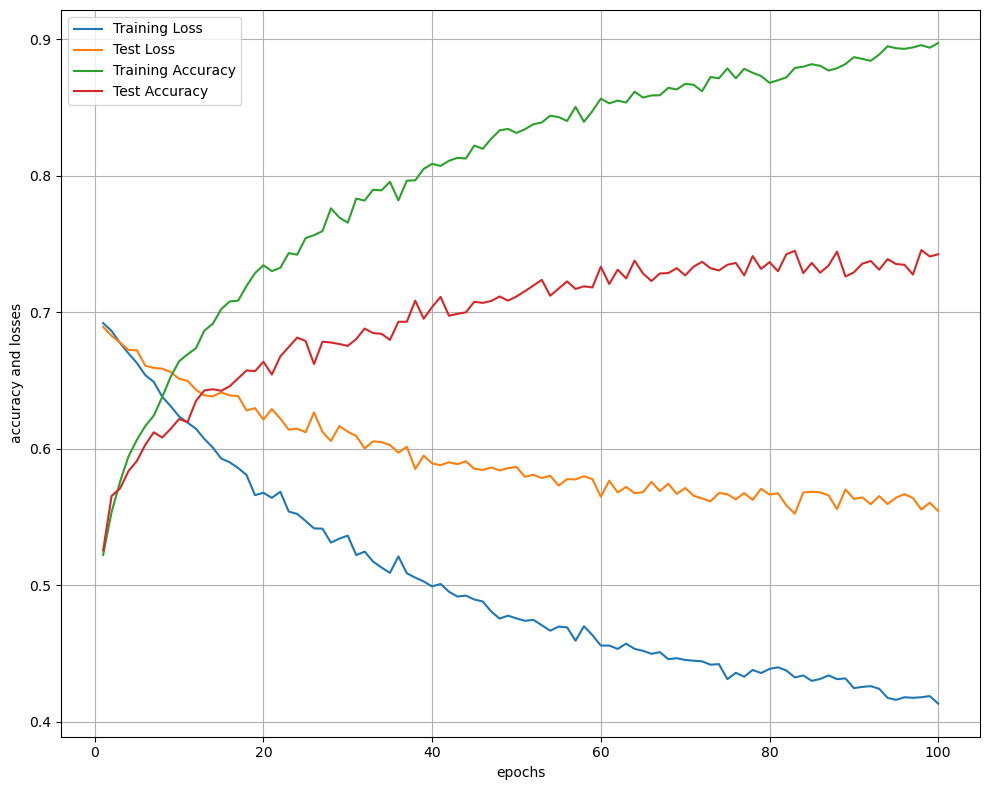

In [46]:
# Now training the model again with the full training dataset and 
# testing on the test dataset after the optimal hyperparameters have been selected
    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):

    train_data = CustomDataset(X_train_scaled,y_train)
    test_data = CustomDataset(X_test_scaled,y_test)
    
    train_dataloader = DataLoader(train_data, batch_size=1024, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=True)
    
    return train_dataloader, test_dataloader

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct

model = FirstHiddenLayerMLP(77,256,2)
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train, y_train, X_test, y_test, 1024)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(test_losses)+1),test_losses,label='Test Loss')
plt.plot(range(1,len(train_accuracies)+1),train_accuracies,label='Training Accuracy')
plt.plot(range(1,len(test_accuracies)+1),test_accuracies,label='Test Accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy and losses')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()